# CLAUDIO RICCI

## Packages

In [2]:
import networkx as nx
import pickle
from networkx.algorithms.approximation import greedy_tsp
import numpy as np

import torch
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

import warnings
from timeit import default_timer as timer
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Helper functions

In [3]:
def tour_length(G, tour):
    """
    Compute the length of a tour. A tour is a list having elments 0 and -1 equal
    """
    assert tour[0] == tour[-1], "Not valid tour"
    estimated = 0
    n = G.number_of_nodes()
    for i in range(n):
        estimated += G[tour[i]][tour[i + 1]]['weight']
    return estimated

def greedy_algorithm(G):
    """
    Run the value of the greedy approximation algorithm on graph G
    """
    return tour_length(G, greedy_tsp(G, weight='weight'))

def random_tour(G, seed = 42):
    """
    Return the value of a random tour
    """
    np.random.seed(seed)
    n = G.number_of_nodes()
    tour = [0]
    for i in range(1, n):
        next_node = np.random.choice([j for j in range(n) if j not in tour])
        tour.append(next_node)
    tour.append(0)
    return tour_length(G, tour)

def transformer_tsp(G, model, DEVICE = 'cpu'):
    """
    Evaluate your (trained) model on G
    """
    # Set the model in evaluation mode
    
    model.eval()

    # Note: number of edges is constant ed equal to n(n-1)/2
    n = G.number_of_nodes()
    
    # Get node coordinates
    attr = nx.get_node_attributes(G, 'pos')
    x = []
    for i in range(n):
        x.append(torch.tensor(attr[i], dtype=torch.float32))

    # From list of tensors to tensor 2d
    x = torch.stack(x)    

    tour = [0]
    y = torch.tensor(tour, dtype=torch.long)
    x = x.to(DEVICE).unsqueeze(0)
    y = y.to(DEVICE).unsqueeze(0)

    with torch.no_grad():
    
        _, tgt_mask, _, _ = create_mask(x, y, DEVICE)
        
        out = model(x, y, None, tgt_mask, None, None)
        
        # Loop until the tour is complete
        while len(tour) < n:
            _, idx = torch.topk(out, n, dim=2)
            for i in range(n):
                # Check if the node is already in the tour
                if idx[0, 0, i] not in tour:
                    tour.append(idx[0, 0, i])
                    break
            y = torch.tensor(tour)
            y = y.to(DEVICE).unsqueeze(0)
    
            tgt_seq_len = y.shape[1]
    
            tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
            
            out = model(x, y, None, tgt_mask, None, None)
            # out = model(x, y)
    
    tour = [int(i) for i in tour] + [0] # Append the starting node (that is hard-coded to 0)
    
    return tour_length(G, tour)

def gap(G, model = None, model_GA = None, random_seed = 42, device = 'cpu'):
    """
    Compute the gap between the optimal solution on graph G and all the analyzed methods
    """
    # Optimal value (hard-coded in the graph)
    TSP = sum([G[i][j]['weight']*G[i][j]['tour'] for (i, j) in G.edges()]) # Optimal

    # Gaps dictionary
    gaps = {'greedy' : 0, 'random' : 0, 'transformer_tsp': 0, 'transformer_tsp_acc_grad': 0}
    gaps['greedy'] = 100* (greedy_algorithm(G) -  TSP) / TSP
    gaps['random'] = 100 * (random_tour(G, random_seed) - TSP) / TSP
    if model is not None:
        gaps['transformer_tsp'] = 100 * (transformer_tsp(G, model, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp'] = float('inf') # In case you just train with GA
        
    if model_GA is not None:
        gaps['transformer_tsp_acc_grad'] = 100 * (transformer_tsp(G, model_GA, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp_acc_grad'] = float('inf') # In case you just train without GA
        
    return gaps

## Dataset & Dataloader

Load the dummy dataset, get a single data item and explain its Python type

In [4]:
with open('/kaggle/input/tspinstances/dummy_20_DLL_ass4.pkl', 'rb') as file:
    dummy = pickle.load(file)

print(type(dummy)) # list
print('Type of a element of the dataset: ', type(dummy[0]))  # The type of the first object -> tuple
print('Type of the first item of the tuple: ', type(dummy[0][0]))  # The type of the first item of a tuple -> Graph
print('Type of the second item of the tuple: ', type(dummy[0][1]))  # The type of the first item of a tuple -> list
print(dummy[0])

<class 'list'>
Type of a element of the dataset:  <class 'tuple'>
Type of the first item of the tuple:  <class 'networkx.classes.graph.Graph'>
Type of the second item of the tuple:  <class 'list'>
(<networkx.classes.graph.Graph object at 0x7b4363613970>, [0, 3, 14, 2, 9, 6, 19, 13, 12, 16, 7, 18, 8, 17, 5, 11, 10, 15, 1, 4, 0])


Describe the edge attributes: `tour` and `weight`

In [5]:
# Extract the graph and tour
graph = dummy[0][0]  # The networkx Graph object
tour = dummy[0][1]   # The tour as a list of nodes

# Inspect edges with attributes
print("Edges and attributes:")
for i, (u, v, data) in enumerate(graph.edges(data=True)):
    if i >= 5:
        break
    print(f"  Edge ({u}, {v}):")
    print('     Weight: ', {data.get('weight', 'Not found')})
    print('     Tour: ',{data.get('tour', 'Not found')})

Edges and attributes:
  Edge (0, 1):
     Weight:  {0.4287846201876535}
     Tour:  {0}
  Edge (0, 2):
     Weight:  {0.20417626260418414}
     Tour:  {0}
  Edge (0, 3):
     Weight:  {0.08154537102129383}
     Tour:  {1}
  Edge (0, 4):
     Weight:  {0.08031174728403137}
     Tour:  {1}
  Edge (0, 5):
     Weight:  {0.5612080164024046}
     Tour:  {0}


Inspect the node attribute `pos`

In [6]:
print("\nNodes and attributes:")
for node, data in graph.nodes(data=True):
    print(f"  Node {node}:")
    print('     Position: ',{data.get('pos', 'Not found')})


Nodes and attributes:
  Node 0:
     Position:  {(0.6049077053425551, 0.5748590937018008)}
  Node 1:
     Position:  {(0.38474987528197846, 0.9428085200806016)}
  Node 2:
     Position:  {(0.6102491981278754, 0.3707527129445174)}
  Node 3:
     Position:  {(0.5497610140601452, 0.514788385568776)}
  Node 4:
     Position:  {(0.5941533303116413, 0.6544475361385552)}
  Node 5:
     Position:  {(0.06187381797691738, 0.433195284467101)}
  Node 6:
     Position:  {(0.7475717305758963, 0.3950876312718402)}
  Node 7:
     Position:  {(0.6548530739834322, 0.06254140180263457)}
  Node 8:
     Position:  {(0.2210796367473482, 0.2142238067774731)}
  Node 9:
     Position:  {(0.6696714621150585, 0.4364218673039507)}
  Node 10:
     Position:  {(0.3206284506117195, 0.7885615893113229)}
  Node 11:
     Position:  {(0.37760295594024584, 0.4963855605324464)}
  Node 12:
     Position:  {(0.8300002368321365, 0.3489482457969727)}
  Node 13:
     Position:  {(0.9983722301898076, 0.2725163812162502)}
  Nod

In [8]:
# Set seed 
torch.manual_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [9]:
# Implement a dataset class. Focus on the getitem method to return:
# – X: A tensor of node coordinates with size 20 × 2.
# – y: A tour starting from 0 and ending with 0.

class GraphDataset(Dataset):
    def __init__(self, data):
        """
        A list of tuples where each tuple contains:
        - A networkx.Graph object
        - A tour (list of node indices)
        """
        self.data = data

    def __len__(self):
        """
        Number of instances in the dataset
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns:
        - X: A tensor of node coordinates with size 20 × 2.
        - y: A tensor representing the tour, starting and ending at 0.
        """
        # Extract the graph and tour
        graph, tour = self.data[idx]

        # Get node positions as a 2D array
        pos = nx.get_node_attributes(graph, 'pos')  # Dictionary {node: (x, y)}
    
        # Ensure nodes are sorted by their index (important for consistent tensor order)
        sorted_positions = [pos[node] for node in sorted(graph.nodes())]
        
        # Convert positions to a tensor of shape (20, 2)
        X = torch.tensor(sorted_positions, dtype=torch.float32)

        # Convert the tour to a tensor
        y = torch.tensor(tour, dtype=torch.long)

        return X, y

In [11]:
with open('/kaggle/input/tspinstances/train_20_DLL_ass4.pkl', 'rb') as file:
    train = pickle.load(file)

with open('/kaggle/input/tspinstances/test_20_DLL_ass4.pkl', 'rb') as file:
    test = pickle.load(file)

with open('/kaggle/input/tspinstances/valid_20_DLL_ass4.pkl', 'rb') as file:
    valid = pickle.load(file)

batch_size = 32

train_dataset = GraphDataset(train)
val_dataset = GraphDataset(valid)
test_dataset = GraphDataset(test)

print(len(train_dataset))

trainloader = DataLoader(train_dataset, batch_size=batch_size)
valloader = DataLoader(val_dataset, batch_size=batch_size)
testloader = DataLoader(test_dataset, batch_size=batch_size)

50000


## Model

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()  # Initialize the parent class (nn.Module)

        # Create a zero matrix
        pos_embedding = torch.zeros((maxlen, emb_size))
        
        # Create a tensor representing positions from 0 to maxlen-1, reshaped to (maxlen, 1)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        
        # Compute the denominator for the positional encoding formula
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        
        # Apply sine function to even indices in the positional embedding matrix
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        
        # Apply cosine function to odd indices in the positional embedding matrix
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        
        # Add an extra dimension to the positional embedding matrix for compatibility with batch processing
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        
        # Register the positional embedding matrix as a buffer (not a trainable parameter)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TSPTransformer(nn.Module):
    def __init__(self, n, num_encoder, num_decoder, de, dd, n_head, dropout, dim_feedforward=1024):
        super().__init__()

        # Encoder
        # Linear layer to project input features (2D coordinates) to the encoder's embedding dimension (de)
        self.linear1 = nn.Linear(2, de)
        
        # Transformer encoder layer with multi-head attention and feedforward network
        encoder_layer = nn.TransformerEncoderLayer(d_model=de, nhead=n_head, dim_feedforward=dim_feedforward, batch_first=True)
        
        # Stack of num_encoder encoder layers
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder)
        
        # Linear layer to project encoder output to the decoder's embedding dimension (dd)
        self.linear2 = nn.Linear(de, dd)

        # Decoder
        # Embedding layer to convert token indices to dense vectors of size dd
        self.embedding = nn.Embedding(n, dd)
        
        # Positional encoding layer to add positional information to decoder embeddings
        self.posEncoding = PositionalEncoding(dd, dropout)
        
        # Transformer decoder layer with multi-head attention and feedforward network
        decoder_layer = nn.TransformerDecoderLayer(d_model=dd, nhead=n_head, dim_feedforward=dim_feedforward, batch_first=True)
        
        # Stack of num_decoder decoder layers
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder)
        
        # Feedforward neural network to project decoder output to the final output size (n)
        self.ffnn = nn.Linear(dd, n)

    def forward(self,
                src: Tensor,  # Source sequence (input to the encoder)
                trg: Tensor,  # Target sequence (input to the decoder)
                src_mask: Tensor,  # Mask for the source sequence
                tgt_mask: Tensor,  # Mask for the target sequence
                src_padding_mask: Tensor,  # Padding mask for the source sequence
                tgt_padding_mask: Tensor):  # Padding mask for the target sequence

        # Encoding
        src = self.linear1(src)
        
        # Pass the source sequence through the encoder with the provided masks
        src = self.encoder(src, mask=src_mask, src_key_padding_mask=src_padding_mask)
        src = self.linear2(src)

        # Decoding
        # Convert target sequence indices to dense embeddings
        trg = self.embedding(trg)
        
        # Add positional encoding to the target embeddings
        trg = self.posEncoding(trg)
        
        # Pass the target sequence and encoder output through the decoder with the provided masks
        output = self.decoder(trg, src, tgt_mask=tgt_mask, memory_mask=None,
                              tgt_key_padding_mask=tgt_padding_mask,
                              memory_key_padding_mask=src_padding_mask)
        
        output = self.ffnn(output)
        
        return output

The following functions are being taken from Exercise 5

In [13]:
def generate_square_subsequent_mask(sequence_length: int) -> Tensor:
    '''
    Function to generate a square subsequent mask for the target sequence
    '''
    # The upper triangular part is set to 1, and the rest is 0
    mask = (torch.triu(torch.ones((sequence_length, sequence_length), device=DEVICE)) == 1).transpose(0, 1)
    
    # Replace 0s with -inf (to mask future positions) and 1s with 0.0 (to allow attention to current and past positions)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))    
    return mask


def create_mask(src, tgt, DEVICE):
    '''
    Function to create masks for the source and target sequences
    '''
    src_seq_len = src.shape[1]  # Source sequence length
    tgt_seq_len = tgt.shape[1]  # Target sequence length

    # Generate a square subsequent mask for the target sequence
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    
    # Create a source mask of zeros (no masking for the source sequence)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = torch.zeros((src.shape[0], src_seq_len), device=DEVICE).bool()  # Source padding mask
    tgt_padding_mask = torch.zeros((tgt.shape[0], tgt_seq_len), device=DEVICE).bool()  # Target padding mask

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [14]:
n = 20
n_enc = 6
n_dec = 6
de = 128
dd = 128
N_HEAD = 8
DROPOUT = 0.3
dim_feedforward=1024

In [15]:
# Create the TSP Transformer model
TSPmodel = TSPTransformer(n, n_enc, n_dec, de, dd, N_HEAD, DROPOUT, dim_feedforward).to(DEVICE)

## Training

### Training WITHOUT gradient accumulation

In [16]:
def train_epoch(model, optimizer, trainloader, loss_fn, DEVICE):
    '''
    Function for training a single epoch
    '''
    # Set the model to training mode
    model.train()
    
    # Initialize a variable to accumulate losses
    losses = 0

    for src, tgt in trainloader:
        src = src.to(DEVICE)  # Node coordinates (input to the encoder)
        tgt = tgt.to(DEVICE)  # Tour indices (target sequence for the decoder)

        tgt_input = tgt[:, :-1]  # Input to the decoder (shifted by one token)
        tgt_out = tgt[:, 1:]  # Target for loss computation (shifted by one token)

        # Zero the gradients to prevent accumulation from previous iterations
        optimizer.zero_grad()

        # Generate masks for attention
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)
        
        # Forward pass
        output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        # Compute the loss
        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1))
        
        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update model weights using the optimizer
        optimizer.step()
        
        # Accumulate the loss for this batch
        losses += loss.item()

    # Return the average loss over all batches in the epoch
    return losses / len(trainloader)

In [17]:
def evaluate(model, valloader, loss_fn, DEVICE, num_heads):
    '''
    Function for evaluation
    '''
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize a variable to accumulate losses
    losses = 0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for src, tgt in valloader:
            src = src.to(DEVICE)  # Node coordinates (input to the encoder)
            tgt = tgt.to(DEVICE)  # Tour indices (target sequence for the decoder)
          
            tgt_input = tgt[:, :-1]  # Input to the decoder (shifted by one token)
            tgt_out = tgt[:, 1:]  # Target for loss computation (shifted by one token)

            # Generate masks for attention
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

            # Forward pass
            output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

            # Compute the loss between the model's output and the target
            loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1))
            
            # Accumulate the loss for this batch
            losses += loss.item()

    # Compute the average loss over all batches in the validation set
    avg_loss = losses / len(valloader)
    
    # Return the average loss
    return avg_loss

In [18]:
warnings.filterwarnings("ignore")

# Hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(TSPmodel.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

NUM_EPOCHS = 15  # Total number of training epochs
train_losses = []  # List to store training losses
val_losses = []  # List to store validation losses
counter = 0  # Counter to track overfitting

best_epoch = 0  # Track the best epoch
print_every = 3  # Print training progress every `print_every` epochs
best_val_loss = float('inf')  # Track the best validation loss

start_tot_time = timer()

# Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    
    # Train for one epoch
    train_loss = train_epoch(TSPmodel, optimizer, trainloader, loss_fn, DEVICE)    
    
    # Evaluate on validation data
    val_loss = evaluate(TSPmodel, valloader, loss_fn, DEVICE, N_HEAD)
    end_time = timer()

    # Check for overfitting
    if best_val_loss < val_loss:
        counter += 1  # Increment counter if validation loss increases
        if counter == 5:  # Stop training if validation loss increases for 5 consecutive epochs
            print(f'Overfitting at epoch {epoch}')
            break
    else:
        counter = 0  # Reset counter if validation loss improves
        best_val_loss = val_loss  # Update the best validation loss
        
        # Save the best model
        torch.save({
                'epoch': epoch,
                'model_state_dict': TSPmodel.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, 'model.pt')
        best_epoch = epoch  # Update the best epoch

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Calculate total training time so far
    end_tot_time = timer() - start_tot_time

    # Print every `print_every` epochs
    if epoch % print_every == 0:
        print(f"Epoch: {epoch}")
        print(f"   Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")
        print(f"   Epoch time = {(end_time - start_time):.3f}s")
    
    # Stop training if total training time exceeds 10 minutes (600 seconds)
    elif end_tot_time >= 600:
        print(f'Reached ten minutes of training without overfitting at epoch {epoch}')
        break

# Print final training results
print(f'Training time: {end_tot_time/60} minutes')
print(f"The best model is obtained at epoch {best_epoch} with a training loss of {train_losses[best_epoch-1]:.3f} and evaluation loss of {best_val_loss:.3f}")

Epoch: 3
   Train loss: 2.018, Val loss: 1.996
   Epoch time = 61.451s
Epoch: 6
   Train loss: 1.995, Val loss: 1.986
   Epoch time = 61.848s
Epoch: 9
   Train loss: 1.986, Val loss: 1.985
   Epoch time = 61.540s
Reached ten minutes of training without overfitting at epoch 10
Training time: 10.293759747100001 minutes
The best model is obtained at epoch 7 with a training loss of 1.991 and evaluation loss of 1.984


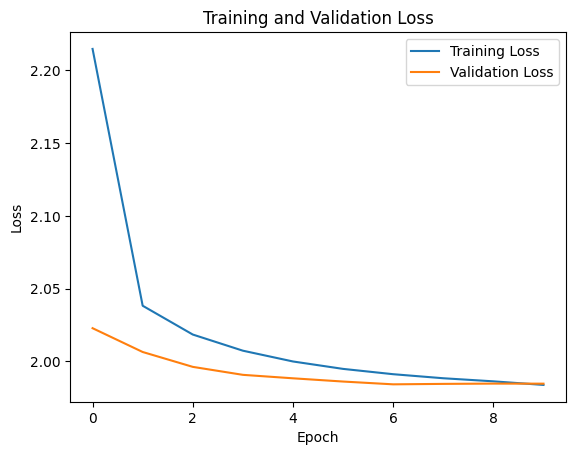

[2.2146573902625573, 2.0382529976119312, 2.0184749207737656, 2.007382700478352, 1.9999737590837388, 1.9948791696410566, 1.9912316653489, 1.9884528027691295, 1.9863329944287214, 1.983869307176928] [2.0228377878665924, 2.0064873434603214, 1.9962707497179508, 1.990795075893402, 1.9884143322706223, 1.9861884415149689, 1.984275195747614, 1.9845802336931229, 1.9847759939730167, 1.9847339428961277]


In [19]:
# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print(train_losses, val_losses)

### Training WITH gradient accumulation

In [20]:
def train_epoch_acc(model, optimizer, trainloader, loss_fn, DEVICE, accum_iter=4):
    # Set the model to training mode
    model.train()
    
    # Initialize a variable to accumulate losses
    losses = 0
    
    # Zero the gradients before starting the epoch
    optimizer.zero_grad()

    for batch_idx, (src, tgt) in enumerate(trainloader):
        src = src.to(DEVICE)  # Node coordinates (input to the encoder)
        tgt = tgt.to(DEVICE)  # Tour indices (target sequence for the decoder)

        tgt_input = tgt[:, :-1]  # Input to the decoder (shifted by one token)
        tgt_out = tgt[:, 1:]  # Target for loss computation (shifted by one token)

        # Generate masks for attention
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

        # Forward pass
        output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
        
        # Compute the loss divided by accum_iter for gradient accumulation
        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1)) / accum_iter
        
        # Backward pass
        loss.backward()

        # Perform gradient clipping and update weights every `accum_iter` batches or at the end of the epoch
        if (batch_idx + 1) % accum_iter == 0 or (batch_idx + 1 == len(trainloader)):
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update model weights
            optimizer.step()
            
            # Zero the gradients for the next accumulation step
            optimizer.zero_grad()

        # Accumulate the actual (unscaled) loss for logging
        losses += loss.item() * accum_iter

    # Return the average loss over all batches in the epoch
    return losses / len(trainloader)

In [21]:
# Define the model to be trained with GA
modelACC = TSPTransformer(n, n_enc, n_dec, de, dd, N_HEAD, DROPOUT, dim_feedforward).to(DEVICE)

In [22]:
warnings.filterwarnings("ignore")

# Hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(modelACC.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

NUM_EPOCHS = 15  # Total number of training epochs
train_losses = []  # List to store training losses
val_losses = []  # List to store validation losses
counter = 0  # Counter to track overfitting

best_epoch = 0  # Track the best epoch
print_every = 3  # Print training progress every `print_every` epochs
best_val_loss = float('inf')  # Track the best validation loss

start_tot_time = timer()

# Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer() 
    
    # Train for one epoch using gradient accumulation
    train_loss = train_epoch_acc(modelACC, optimizer, trainloader, loss_fn, DEVICE, 6)    
    
    # Evaluate on validation data
    val_loss = evaluate(modelACC, valloader, loss_fn, DEVICE, N_HEAD)
    end_time = timer()  # End the epoch timer

    # Check for overfitting
    if best_val_loss < val_loss:
        counter += 1  # Increment counter if validation loss increases
        if counter == 5:  # Stop training if validation loss increases for 5 consecutive epochs
            print(f'Overfitting at epoch {epoch}')
            break
    else:
        counter = 0  # Reset counter if validation loss improves
        best_val_loss = val_loss  # Update the best validation loss
        
        # Save the best model
        torch.save({
                'epoch': epoch,
                'model_state_dict': modelACC.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, 'model_acc.pt')
        best_epoch = epoch  # Update the best epoch

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Calculate total training time so far
    end_tot_time = timer() - start_tot_time

    # Print training progress every `print_every` epochs
    if epoch % print_every == 0:
        print(f"Epoch: {epoch}")
        print(f"   Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")
        print(f"   Epoch time = {(end_time - start_time):.3f}s")
    
    # Stop training if total training time exceeds 10 minutes (600 seconds)
    elif end_tot_time >= 600:
        print(f'Reached ten minutes of training without overfitting at epoch {epoch}')
        break

# Print final training results
print(f'Training time: {end_tot_time/60} minutes')
print(f"The best model is obtained at epoch {best_epoch} with a training loss of {train_losses[best_epoch-1]} and evaluation loss of {best_val_loss}")

Epoch: 3
   Train loss: 2.049, Val loss: 2.002
   Epoch time = 56.314s
Epoch: 6
   Train loss: 2.015, Val loss: 1.993
   Epoch time = 56.628s
Epoch: 9
   Train loss: 2.002, Val loss: 1.988
   Epoch time = 56.466s
Reached ten minutes of training without overfitting at epoch 11
Training time: 10.374067082849997 minutes
The best model is obtained at epoch 11 with a training loss of 1.9963401711604873 and evaluation loss of 1.9864810965955257


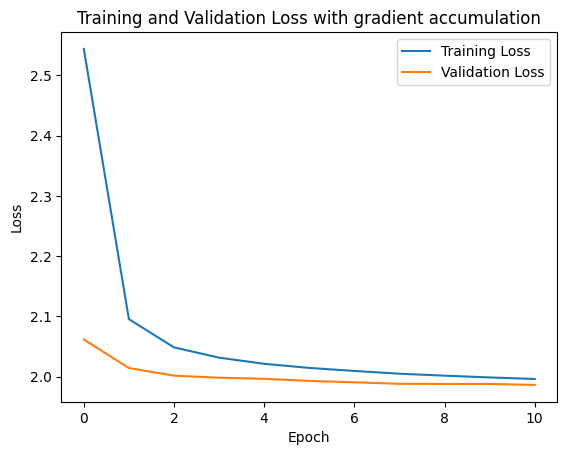

[2.5435670700045785, 2.0955066033379817, 2.0487138147317516, 2.0316798215635448, 2.021482400724847, 2.0146686615504596, 2.009657084255438, 2.0050458825709954, 2.0018419547868094, 1.998883357775646, 1.9963401711604873] [2.061806298792362, 2.014474779367447, 2.0018422678112984, 1.9984663352370262, 1.9966491982340813, 1.9931648932397366, 1.9908340349793434, 1.988342773169279, 1.9880718551576138, 1.9880682155489922, 1.9864810965955257]


In [23]:
# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with gradient accumulation')
plt.legend()
plt.show()

print(train_losses, val_losses)

## Testing

Test your model on the test set and compare it with two baselines:

- random tour: Samples a random tour.
- greedy algorithm: Starts from a node and selects the closest unvisited
node iteratively.

If you want to load pre-trained model

In [24]:
# model = TSPTransformer(n, n_enc, n_dec, de, dd, N_HEAD, DROPOUT, dim_feedforward).to(DEVICE)
# checkpoint = torch.load('/kaggle/input/tsp_models/pytorch/default/1/model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])

# modelACC = TSPTransformer(n, n_enc, n_dec, de, dd, N_HEAD, DROPOUT, dim_feedforward).to(DEVICE)
# checkpoint = torch.load('/kaggle/input/tsp_models/pytorch/default/1/model_acc.pt')
# modelACC.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [25]:
graph, tour = test[0]
graph, tour

(<networkx.classes.graph.Graph at 0x7b4420ca9ba0>,
 [0, 4, 5, 9, 18, 15, 11, 10, 2, 8, 12, 3, 7, 6, 16, 1, 13, 19, 14, 17, 0])

In [26]:
# Lists to store gaps
gaps_random = []
gaps_greedy = []
gaps_model = []         # Model without gradient accumulation
gaps_model_ga = []      # Model with gradient accumulation

# Iterate over the test set
for G, _ in test:
    # Compute gaps
    gaps = gap(G, model, modelACC, device=DEVICE)

    # Store the gaps for each method
    gaps_random.append(gaps['random'])
    gaps_greedy.append(gaps['greedy'])
    gaps_model.append(gaps['transformer_tsp'])
    gaps_model_ga.append(gaps['transformer_tsp_acc_grad'])

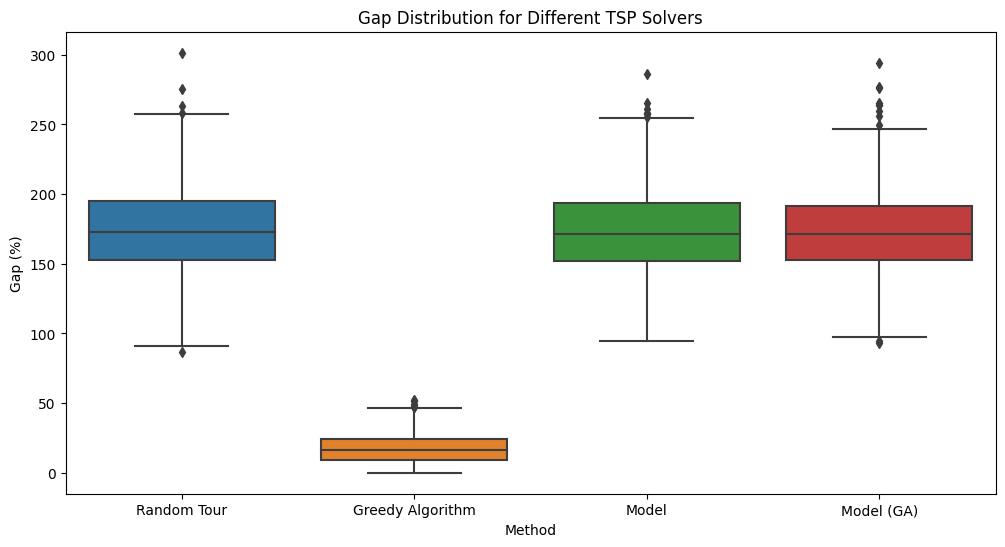

In [27]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Combine all gaps into a DataFrame for plotting
data = pd.DataFrame({
    'Random Tour': gaps_random,
    'Greedy Algorithm': gaps_greedy,
    'Model': gaps_model,
    'Model (GA)': gaps_model_ga
})

# Melt the DataFrame for seaborn boxplot
data_melted = data.melt(var_name='Method', value_name='Gap')

# Create boxplots
sns.boxplot(x='Method', y='Gap', data=data_melted)

# Add plot title and labels
plt.title('Gap Distribution for Different TSP Solvers')
plt.xlabel('Method')
plt.ylabel('Gap (%)')

# Show the plot
plt.show()